# Traditional classification methods with dimensionality reduction

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

## Función útil

In [2]:
def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return acc, f1, recall, precision, cm

def return_parameters(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return {'accuracy': acc, 'f1': f1, 'recall': recall, 'precision': precision}

## Preparation

In [3]:
#df
emotion_df = pd.read_csv("./emotion.csv")

Cleaning

In [4]:
e_df = emotion_df.fillna(0)

Data separation

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Cargar X y Y
X = e_df.iloc[: ,:-1].values
Y = e_df['Emotions'].values
# Para dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, train_size=0.8)

#escalarlos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376), (38918,), (9730, 2376), (9730,))

## Reducción de la dimensionalidad (LDA y UMAP)

LDA

In [6]:
#LDA
lda = LDA(n_components=6)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

UMAP

c:\Users\Matías\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


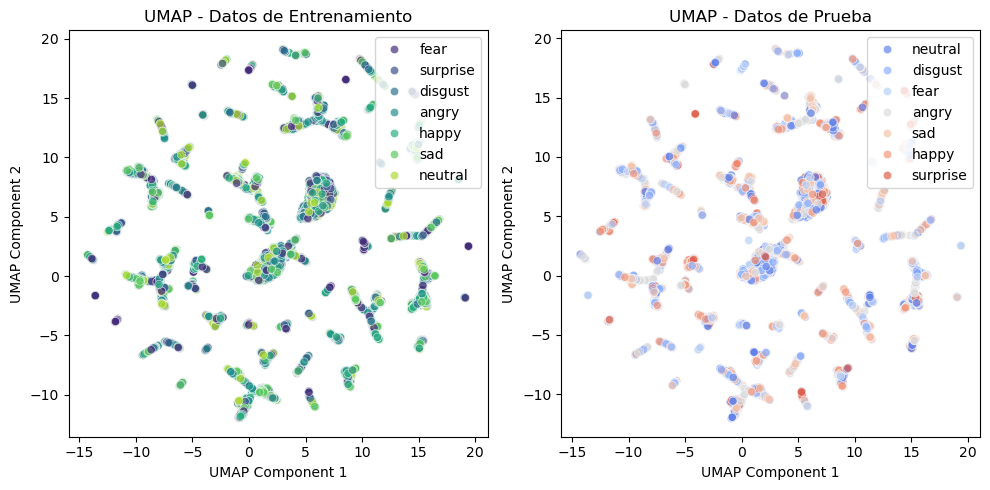

In [7]:
#UMAP
umap_model = UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

#como usamos 2d puedo graficarlo
plt.figure(figsize=(10, 5))

# datos de entrenamiento
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=y_train, palette="viridis", alpha=0.7)
plt.title("UMAP - Datos de Entrenamiento")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# datos de prueba
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=y_test, palette="coolwarm", alpha=0.7)
plt.title("UMAP - Datos de Prueba")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

## Clasificación (SVM, XGBoost y KNN)

In [8]:
classifiers = {
    'SVM': SVC(random_state=0, kernel='poly', degree=4),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}

### LDA

#### SVM

In [9]:
# SVM con LDA
svm_lda = classifiers['SVM']
svm_lda.fit(X_train_lda, y_train)
y_pred_svm_lda = svm_lda.predict(X_test_lda)
results['SVM with LDA'] = evaluate_model(y_test, y_pred_svm_lda)

#### XGBoost

In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgboost_lda = classifiers['XGBoost']
xgboost_lda.fit(X_train_lda, y_train_encoded)
y_pred_xgboost_lda = xgboost_lda.predict(X_test_lda)
results['XGBoost with LDA'] = evaluate_model(y_test_encoded, y_pred_xgboost_lda)

c:\Users\Matías\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### KNN

In [11]:
knn_lda = classifiers['KNN']
knn_lda.fit(X_train_lda, y_train)
y_pred_knn_lda = knn_lda.predict(X_test_lda)
results['KNN with LDA'] = evaluate_model(y_test, y_pred_knn_lda)

### UMAP

#### SVM

In [12]:
# SVM con UMAP
svm_umap = classifiers['SVM']
svm_umap.fit(X_train_umap, y_train)
y_pred_svm_umap = svm_umap.predict(X_test_umap)
results['SVM with UMAP'] = evaluate_model(y_test, y_pred_svm_umap)

c:\Users\Matías\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### XGBoost

In [13]:
xgboost_umap = classifiers['XGBoost']
xgboost_umap.fit(X_train_umap, y_train_encoded)
y_pred_xgboost_umap = xgboost_umap.predict(X_test_umap)
results['XGBoost with UMAP'] = evaluate_model(y_test_encoded, y_pred_xgboost_umap)

c:\Users\Matías\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### KNN

In [14]:
knn_umap = classifiers['KNN']
knn_umap.fit(X_train_umap, y_train)
y_pred_knn_umap = knn_umap.predict(X_test_umap)
results['KNN with UMAP'] = evaluate_model(y_test, y_pred_knn_umap)

## Evaluación

SVM with LDA - Accuracy: 0.3205549845837616, F1-score: 0.3181773164234355, Recall: 0.3205549845837616, Precision: 0.3990994804287177


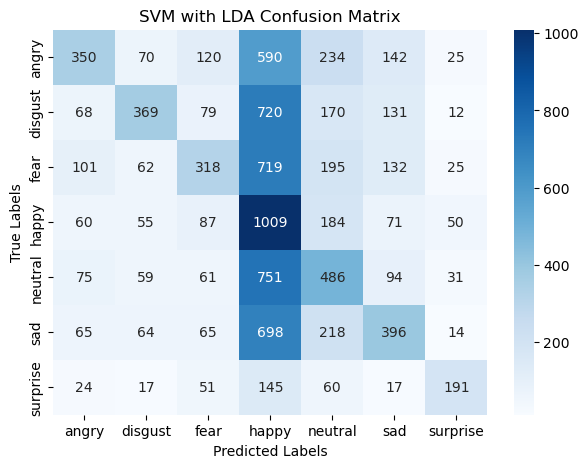

XGBoost with LDA - Accuracy: 0.4553956834532374, F1-score: 0.45546112349695467, Recall: 0.4553956834532374, Precision: 0.45645187401935056


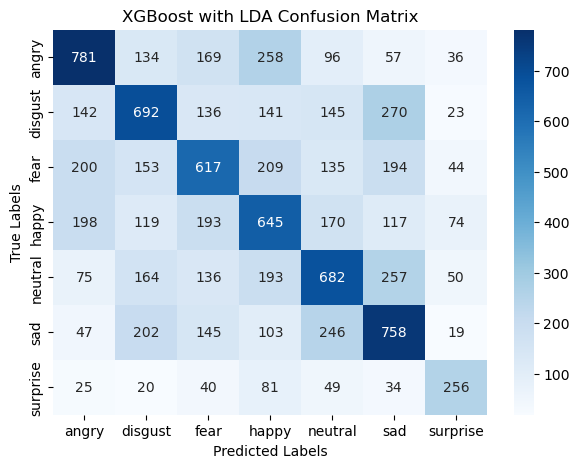

KNN with LDA - Accuracy: 0.420863309352518, F1-score: 0.419785331354162, Recall: 0.420863309352518, Precision: 0.4209970179180488


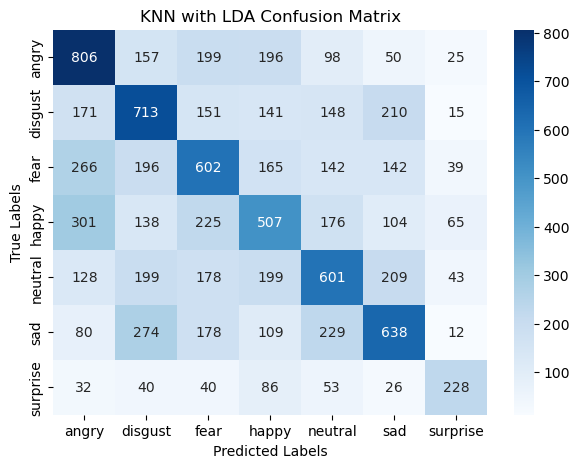

SVM with UMAP - Accuracy: 0.17235354573484069, F1-score: 0.1044239019344166, Recall: 0.17235354573484069, Precision: 0.1546184050023905


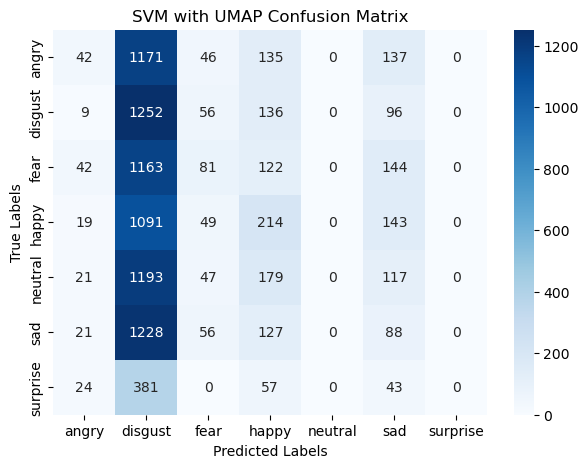

XGBoost with UMAP - Accuracy: 0.36772867420349437, F1-score: 0.3646103914800074, Recall: 0.36772867420349437, Precision: 0.3701208932755384


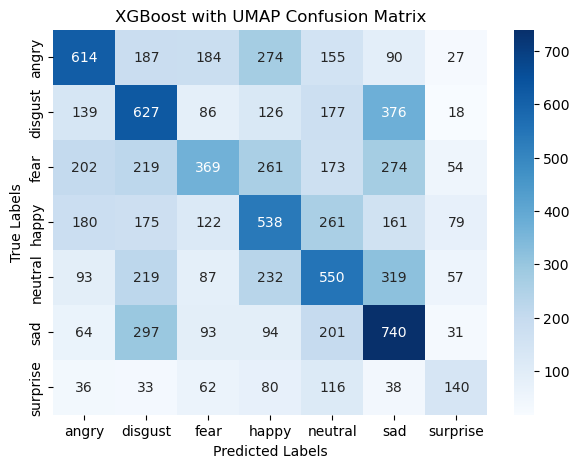

KNN with UMAP - Accuracy: 0.34367934224049335, F1-score: 0.34200132398198074, Recall: 0.34367934224049335, Precision: 0.3434892298820209


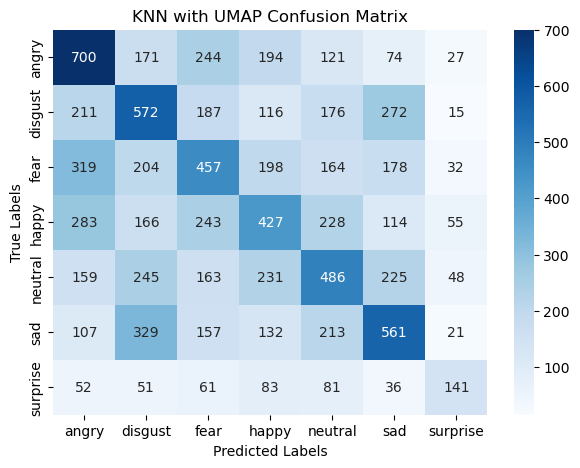

In [15]:
for model, metrics in results.items():
    print(f"{model} - Accuracy: {metrics[0]}, F1-score: {metrics[1]}, Recall: {metrics[2]}, Precision: {metrics[3]}")
    
    # Mostrar matrices de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(metrics[4], annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
    plt.title(f'{model} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## Búsqueda de mejores hiperparámetros

### SVM

SVM con LDA

In [16]:
results_svm_lda = {}

# SVM con kernel 'poly' de grado de 4 a 6
for degree in range(4, 6):
    model = SVC(random_state=0, kernel='poly', degree=degree)
    model.fit(X_train_lda, y_train_encoded)
    y_pred = model.predict(X_test_lda)
    results_svm_lda[f'SVM Poly Degree {degree} with LDA'] = return_parameters(y_test_encoded, y_pred)

# SVM con kernel 'rbf'
model_rbf = SVC(random_state=0, kernel='rbf')
model_rbf.fit(X_train_lda, y_train_encoded)
y_pred_rbf = model_rbf.predict(X_test_lda)
results_svm_lda['SVM RBF with LDA'] = return_parameters(y_test_encoded, y_pred_rbf)

# mejor modelo segun el F1 Score
best_model_name = max(results_svm_lda, key=lambda x: results_svm_lda[x]['f1'])
best_model_metrics = results_svm_lda[best_model_name]

# resultados del mejor modelo
print("\nMejor modelo (según F1 Score):")
print(f"{best_model_name}")
for metric, value in best_model_metrics.items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")


Mejor modelo (según F1 Score):
SVM RBF with LDA
  Accuracy: 0.4626
  F1: 0.4627
  Recall: 0.4626
  Precision: 0.4647


SVM con UMAP

In [ ]:
results_svm_umap = {}

# SVM con kernel 'poly' de grado de 4 a 6
for degree in range(4, 6):
    model = SVC(random_state=0, kernel='poly', degree=degree)
    model.fit(X_train_umap, y_train_encoded)
    y_pred = model.predict(X_test_umap)
    results_svm_umap[f'SVM Poly Degree {degree} with UMAP'] = return_parameters(y_test_encoded, y_pred)

# SVM con kernel 'rbf'
model_rbf = SVC(random_state=0, kernel='rbf')
model_rbf.fit(X_train_umap, y_train_encoded)
y_pred_rbf = model_rbf.predict(X_test_umap)
results_svm_umap['SVM RBF with UMAP'] = return_parameters(y_test_encoded, y_pred_rbf)

# mejor modelo según el F1 Score
best_model_name_umap = max(results_svm_umap, key=lambda x: results_svm_umap[x]['f1'])
best_model_metrics_umap = results_svm_umap[best_model_name_umap]

# resultados del mejor modelo
print("\nMejor modelo con UMAP (según F1 Score):")
print(f"{best_model_name_umap}")
for metric, value in best_model_metrics_umap.items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")

c:\Users\Matías\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### KNN

KNN con LDA

In [17]:
results_knn_lda = {}

# KNN con diferentes numeros de vecinos (1 a 12)
for n_neighbors in range(1, 13):
    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    model_knn.fit(X_train_lda, y_train_encoded)
    y_pred_knn = model_knn.predict(X_test_lda)
    results_knn_lda[f'KNN {n_neighbors} Neighbors with LDA'] = return_parameters(y_test_encoded, y_pred_knn)

# mejor modelo segun el F1 Score
best_model_name_knn = max(results_knn_lda, key=lambda x: results_knn_lda[x]['f1'])
best_model_metrics_knn = results_knn_lda[best_model_name_knn]

# resultados del mejor modelo
print("\nMejor modelo con KNN y LDA (según F1 Score):")
print(f"{best_model_name_knn}")
for metric, value in best_model_metrics_knn.items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")


Mejor modelo con KNN y LDA (según F1 Score):
KNN 12 Neighbors with LDA
  Accuracy: 0.4398
  F1: 0.4395
  Recall: 0.4398
  Precision: 0.4401


KNN con UMAP

In [18]:
from sklearn.neighbors import KNeighborsClassifier

results_knn_umap = {}

# KNN con diferentes numeros de vecinos (1 a 12)
for n_neighbors in range(1, 13):
    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    model_knn.fit(X_train_umap, y_train_encoded)
    y_pred_knn = model_knn.predict(X_test_umap)
    results_knn_umap[f'KNN {n_neighbors} Neighbors with UMAP'] = return_parameters(y_test_encoded, y_pred_knn)

# mejor modelo según el F1 Score
best_model_name_knn_umap = max(results_knn_umap, key=lambda x: results_knn_umap[x]['f1'])
best_model_metrics_knn_umap = results_knn_umap[best_model_name_knn_umap]

# resultados del mejor modelo
print("\nMejor modelo con KNN y UMAP (según F1 Score):")
print(f"{best_model_name_knn_umap}")
for metric, value in best_model_metrics_knn_umap.items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")


Mejor modelo con KNN y UMAP (según F1 Score):
KNN 12 Neighbors with UMAP
  Accuracy: 0.3657
  F1: 0.3627
  Recall: 0.3657
  Precision: 0.3630


### XGBoost

XGBoost con LDA

In [20]:

xgb_model = XGBClassifier(learning_rate=0.01, use_label_encoder=False, eval_metric='logloss')

# parámetros a buscar
param_grid = {
    'max_depth': [3, 6, 9],            # profundidad maxima del árbol
    'n_estimators': [100, 200, 300]   # # árboles a construir
}

# configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # metrica para optimizar
    cv=5,                # validación cruzada
    verbose=2,           # progreso
    n_jobs=-1            # cores
)

# ajustar el modelo con los datos transformados por LDA
grid_search.fit(X_train_lda, y_train_encoded)

# obtener el mejor modelo
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# mejor modelo
y_pred_best_xgb = best_xgb_model.predict(X_test_lda)
results['Best XGBoost with LDA'] = return_parameters(y_test_encoded, y_pred_best_xgb)

# mejores parametros y resultados
print("\nMejores hiperparámetros encontrados:")
print(best_params)

print("\nResultados del mejor modelo:")
for metric, value in results['Best XGBoost with LDA'].items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Matías\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Mejores hiperparámetros encontrados:
{'max_depth': 6, 'n_estimators': 300}

Resultados del mejor modelo:
  Accuracy: 0.4577
  F1: 0.4570
  Recall: 0.4577
  Precision: 0.4577


XGBoost con UMAP

In [21]:
xgb_model = XGBClassifier(learning_rate=0.01, use_label_encoder=False, eval_metric='logloss')

# parametros a buscar
param_grid = {
    'max_depth': [3, 6, 9],            # profundidad maxima del árbol
    'n_estimators': [100, 200, 300]   # arboles a construir
}

# configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # metrica para optimizar
    cv=5,                # validación cruzada
    verbose=2,           # progreso
    n_jobs=-1            # cores
)

# ajustar el modelo con los datos transformados por UMAP
grid_search.fit(X_train_umap, y_train_encoded)

# obtener el mejor modelo
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# mejor modelo
y_pred_best_xgb = best_xgb_model.predict(X_test_umap)
results['Best XGBoost with UMAP'] = return_parameters(y_test_encoded, y_pred_best_xgb)

# mejores parámetros y resultados
print("\nMejores hiperparámetros encontrados:")
print(best_params)

print("\nResultados del mejor modelo:")
for metric, value in results['Best XGBoost with UMAP'].items():
    if metric != 'confusion_matrix':
        print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"  {metric.capitalize()}:\n{value}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Matías\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Mejores hiperparámetros encontrados:
{'max_depth': 9, 'n_estimators': 300}

Resultados del mejor modelo:
  Accuracy: 0.3470
  F1: 0.3434
  Recall: 0.3470
  Precision: 0.3538


No obstante podemos ver que en el intento superior    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0), funciona mejor